# Mitosis analysis
In this example we analyze a cell going through mitosis event in one of the datasets (DIC-C2DH-HeLa) from [Cell Tracking Challenge](http://celltrackingchallenge.net/2d-datasets/)

`output` directory was generated with:
```
python .\src\export.py .\data\img\ .\data\seg\
```
Where img folder contains all iamges from 01 directory, and seg from the 01_ST

In [380]:
import numpy as np
from DescriptorLibUtils import DataExplorer

de = DataExplorer("../output/")

In [381]:
de.GetAllCellsInFrame(0)

dict_keys([1, 5, 7, 11, 15, 19, 23, 27, 32, 34])

In [382]:
cell_id = 1
imgs, masks = de.GetCellTimeline(cell_id)
print(len(imgs))

30


In images below, we can see last few images before the mitosis event. After the last frame, two new cells are created

30


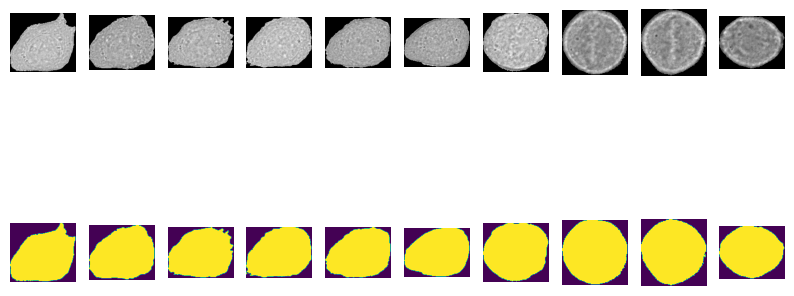

In [383]:
import matplotlib.pyplot as plt
n = 10
imgs_last = imgs[-n:]
masks_last = masks[-n:]
print(len(imgs))
fig, ax = plt.subplots(2, n, figsize=(10, 5))
for idx,(img, mask) in enumerate(zip(imgs_last, masks_last)):
    ax[0, idx].imshow(img, cmap="gray")
    ax[1, idx].imshow(mask)
    ax[0, idx].axis("off")
    ax[1, idx].axis("off")

## Mask descriptors
Mask descriptors are values computed only from mask

In [384]:
de.GetDescriptorsForCell(0,cell_id)["Mask descriptors"]

(<DescriptorType.DICT_SCALAR: 4>,
 {'area': 12844,
  'perimeter': 574.7422074112307,
  'convex_perimeter': 513.2447327281724,
  'major_axis': 0,
  'minor_axis': 0,
  'bbox_size': 23940,
  'elongation': 0.8187134502923976,
  'compactness': 0.48861182997044317,
  'circularity': 0.6127187335317562,
  'convexity': 0.8929998982325366})

In [385]:
mask_timeline = de.GetCellDescriptorTimeline(cell_id, "Mask descriptors")

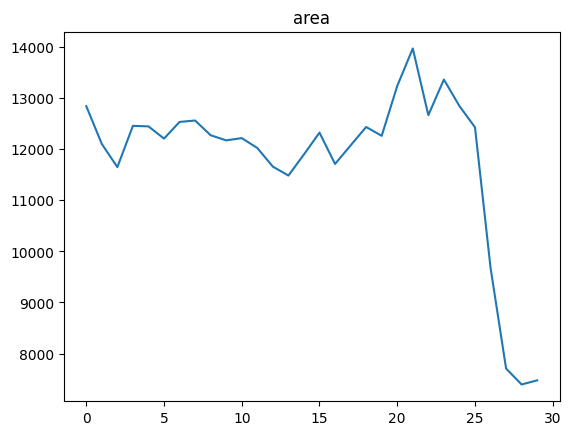

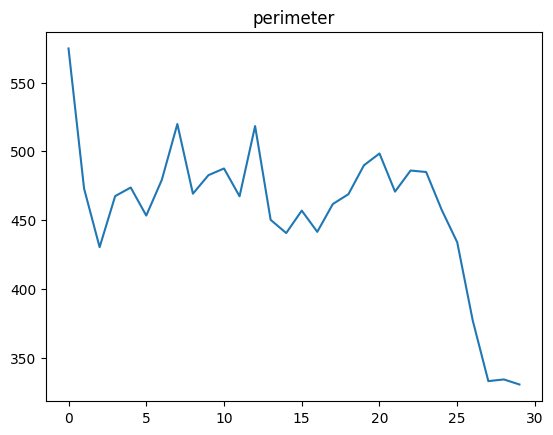

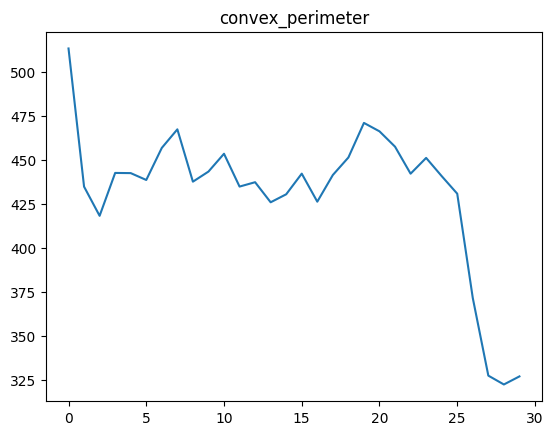

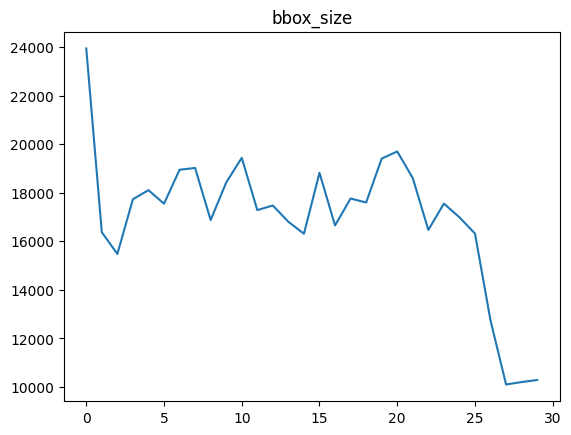

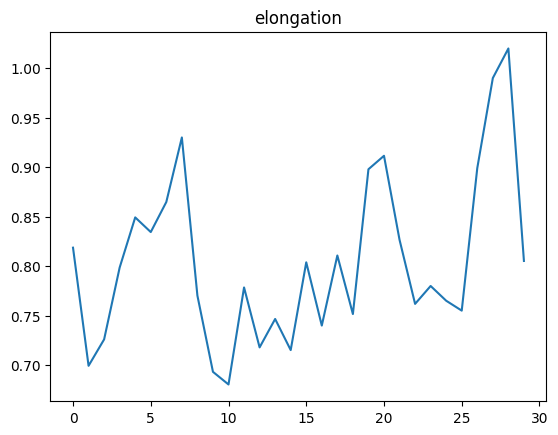

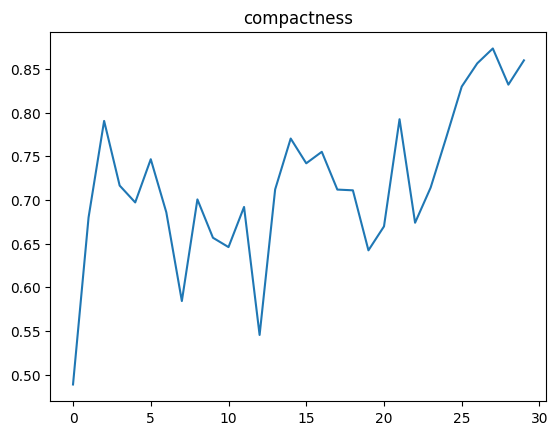

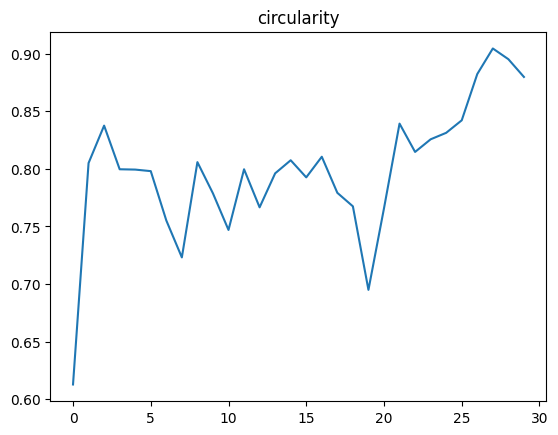

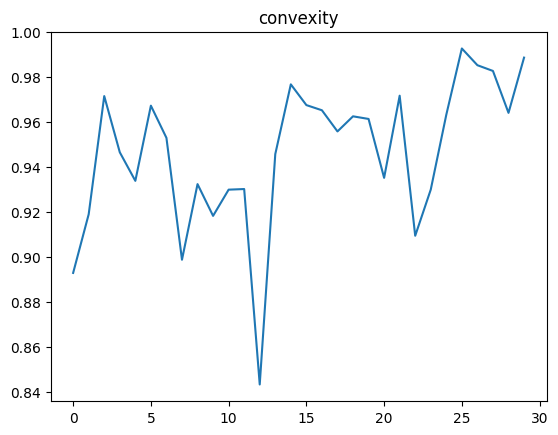

In [386]:
keys = list(de.GetDescriptorsForCell(0,cell_id)["Mask descriptors"][1].keys())
for key in keys:
    vals = de.GetCellDescriptorTimeline(cell_id, "Mask descriptors", key)
    if np.sum(vals) == 0:
        continue
    plt.plot(vals)
    plt.title(key)
    plt.show()
    plt.close()

## Intensity descriptors
These descriptors use values of the cell within the mask

### Histogram descriptos


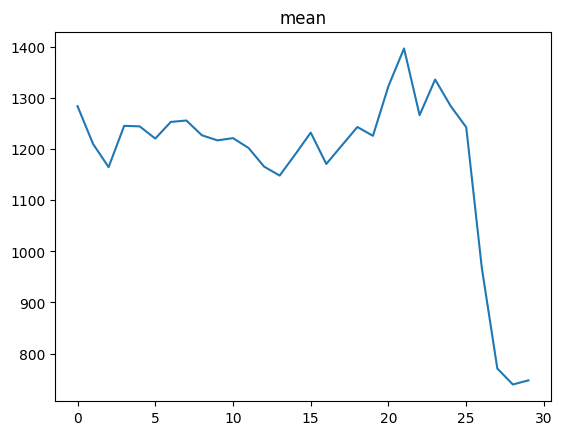

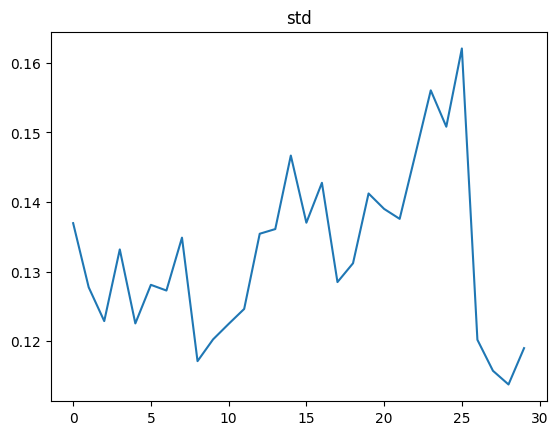

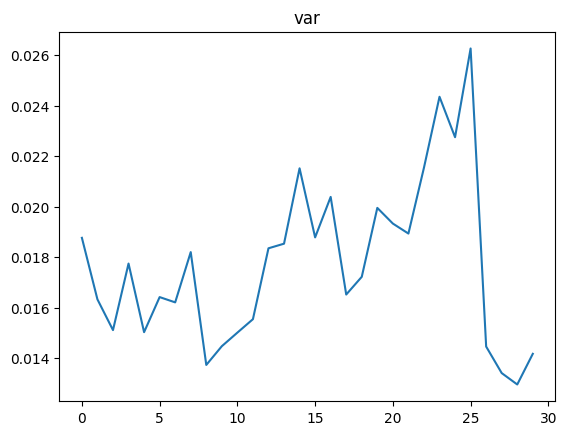

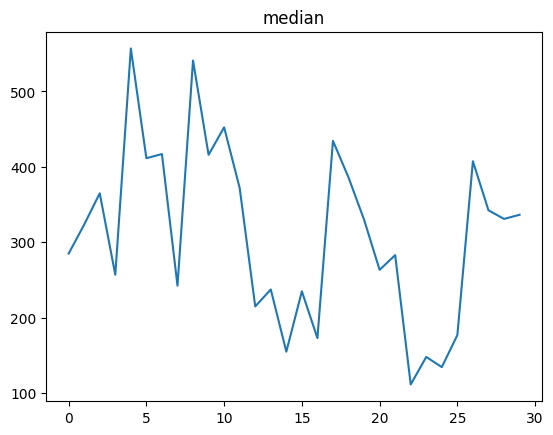

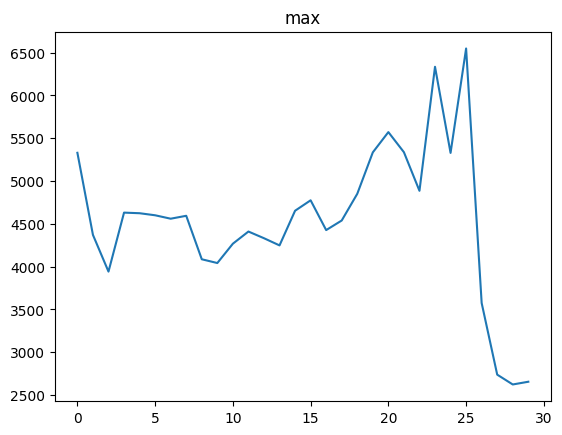

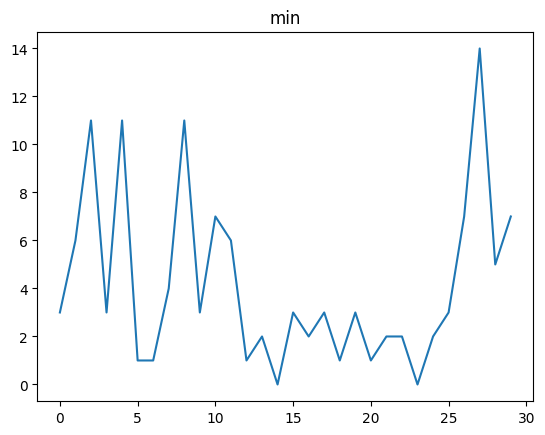

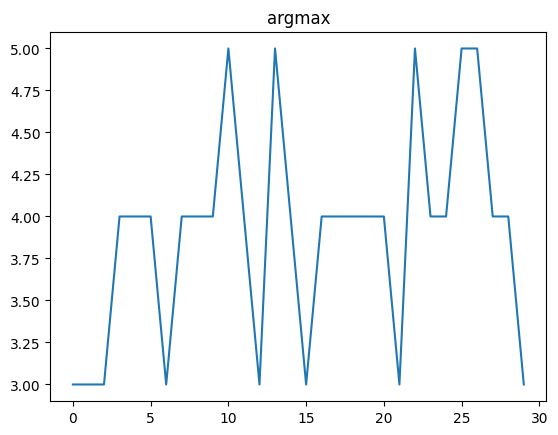

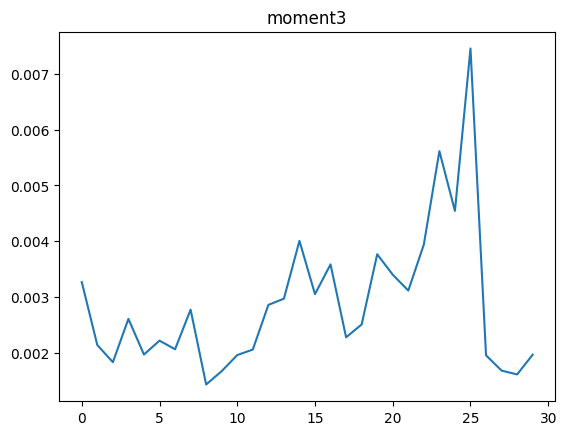

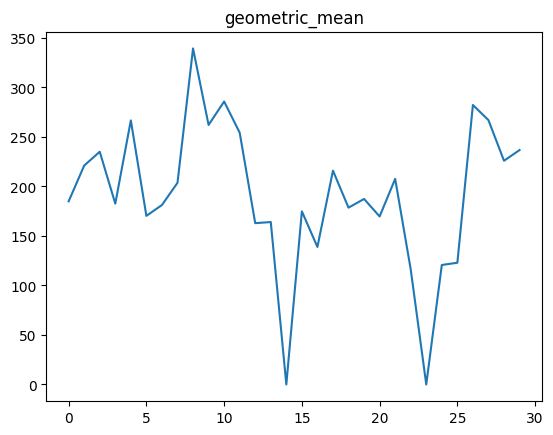

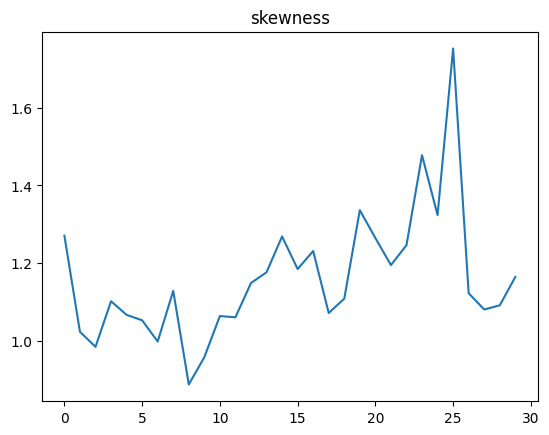

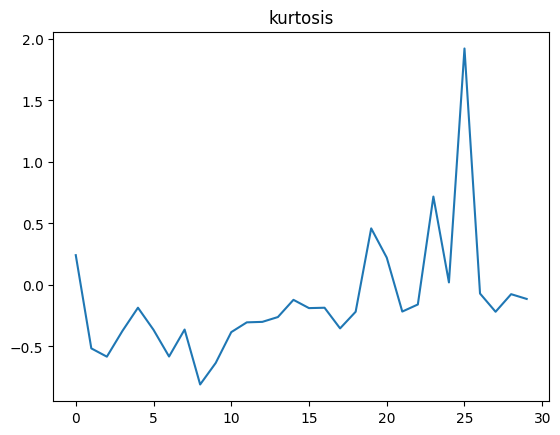

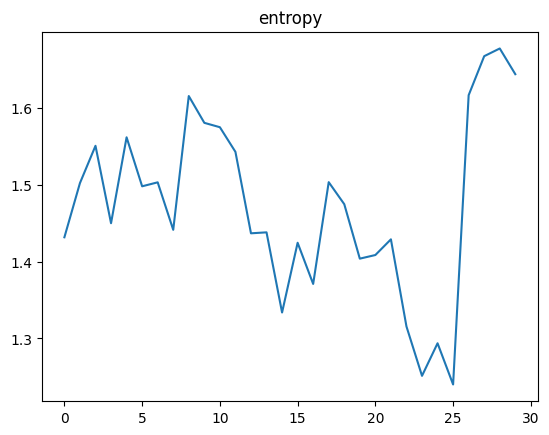

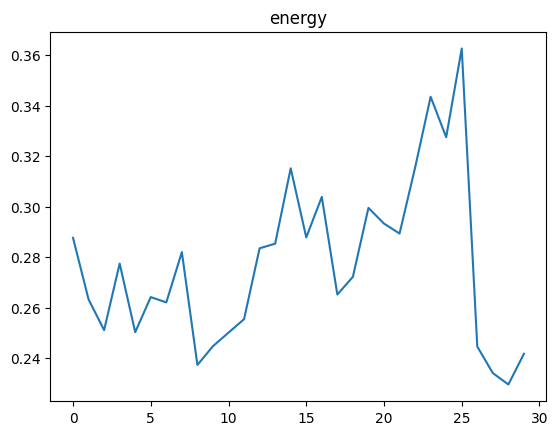

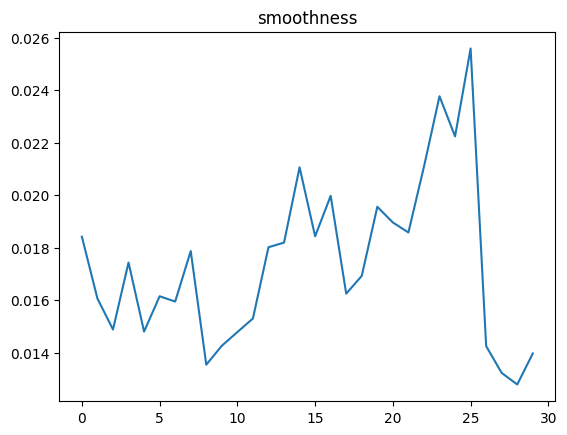

In [387]:
keys = list(de.GetDescriptorsForCell(0,cell_id)["Histogram descriptors"][1].keys())
for key in keys:
    vals = de.GetCellDescriptorTimeline(cell_id, "Histogram descriptors", key)
    if np.sum(vals) == 0:
        continue
    plt.plot(vals)
    plt.title(key)
    plt.show()
    plt.close()

30


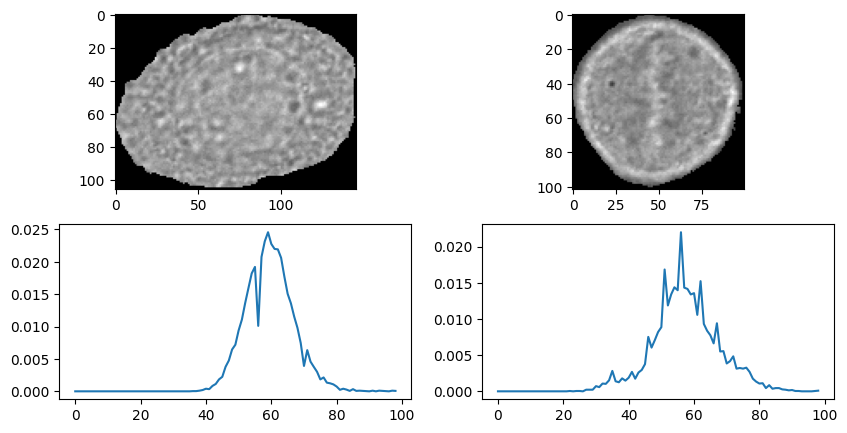

In [388]:
from DescriptorLib.descriptors import Histogram

cell_imgs, _ = de.GetCellTimeline(cell_id)
print(len(cell_imgs))
early = cell_imgs[2]
late = cell_imgs[-2]
_, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].imshow(early, cmap="gray")
ax[0, 1].imshow(late, cmap="gray")
ax[1, 0].plot(np.histogram(early, bins=100, density=True)[0][1:])
ax[1, 1].plot(np.histogram(late, bins=100, density=True)[0][1:])

### Texture descriptors

In [389]:
de.GetDescriptorsForCell(0, cell_id).keys()

dict_keys(['bbox', 'Mask descriptors', 'Histogram descriptors', 'Moments', 'Moments central', 'Moments Hu', 'Glcm features', 'Granulometry', 'Power spectrum', 'Autocorrelation', 'Local binary pattern', 'Gabor energy'])

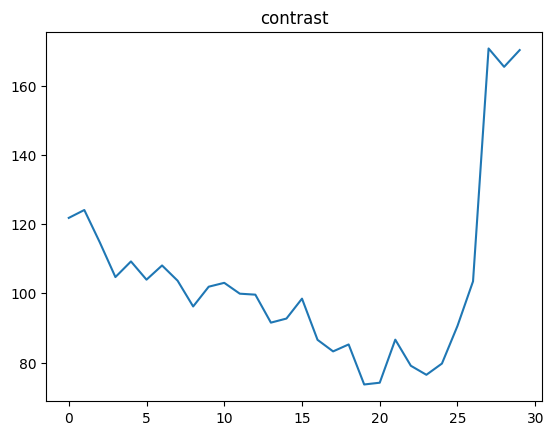

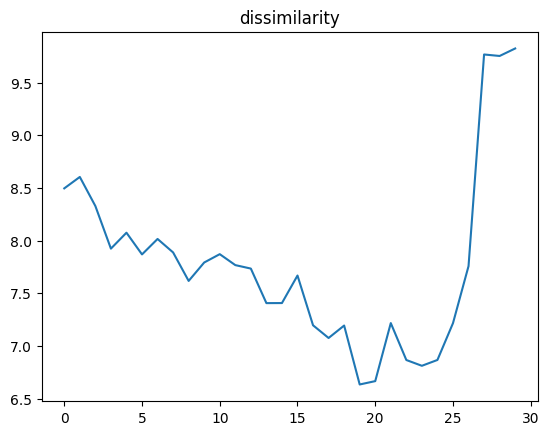

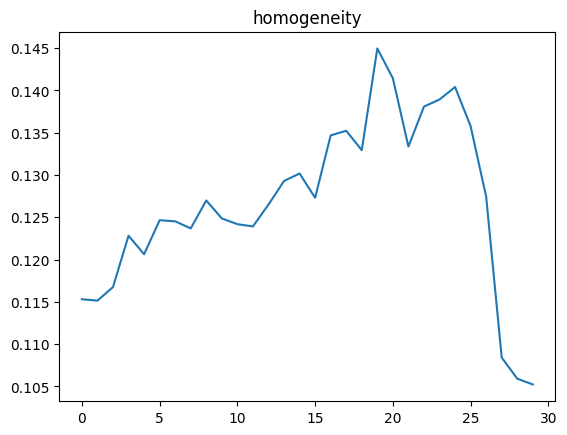

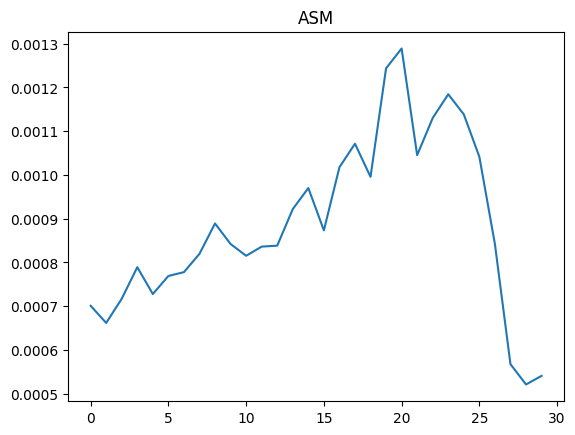

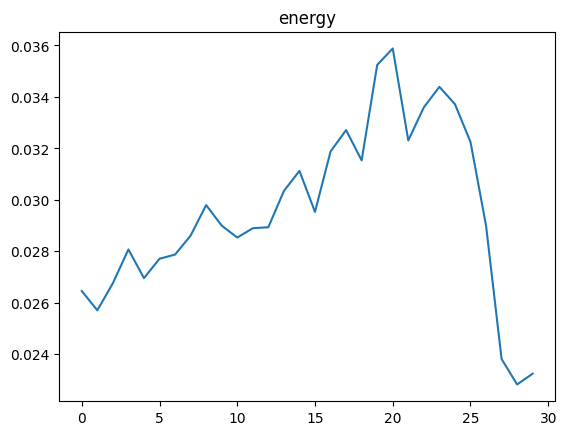

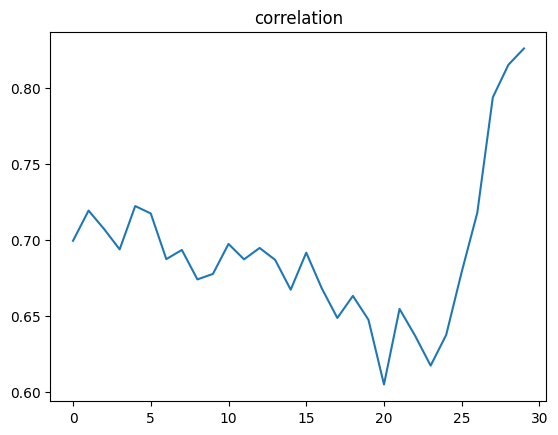

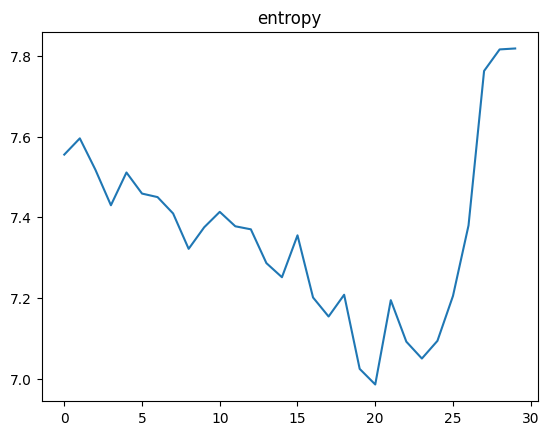

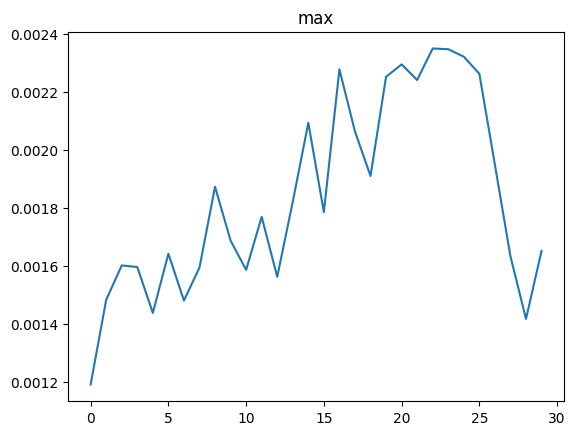

In [390]:
keys = list(de.GetDescriptorsForCell(0,cell_id)["Glcm features"][1].keys())
for key in keys:
    vals = de.GetCellDescriptorTimeline(cell_id, "Glcm features", key)
    if np.sum(vals) == 0:
        continue
    plt.plot(vals)
    plt.title(key)
    plt.show()
    plt.close()

#### Gabor

In [391]:
energies = de.GetCellDescriptorTimeline(cell_id, "Gabor energy", 0)
n = len(energies)

energy_matrix = np.zeros((n, len(energies[0][1])))
for idx, energy in enumerate(energies):
    energy_matrix[idx] = energy[1]
energy_matrix = np.array(energy_matrix)

normaliized = energy_matrix - np.min(energy_matrix, axis=0)
normaliized = normaliized / np.max(normaliized, axis=0)
std_devs = np.std(normaliized, axis=0)
#plt.plot(std_devs)


best_energy = np.argmax(std_devs)
print(best_energy)
worse_energy = np.argmin(std_devs)

10


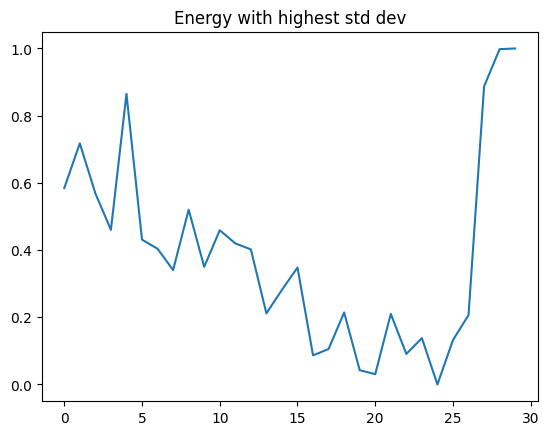

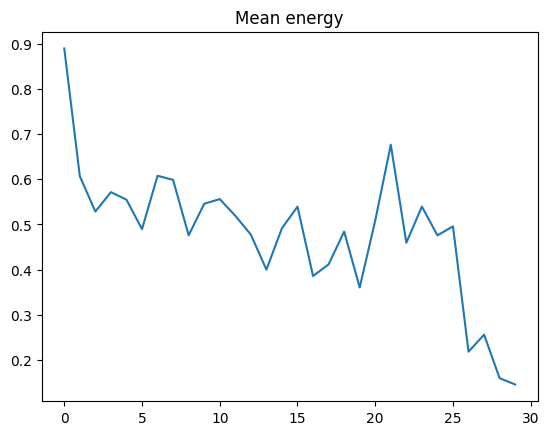

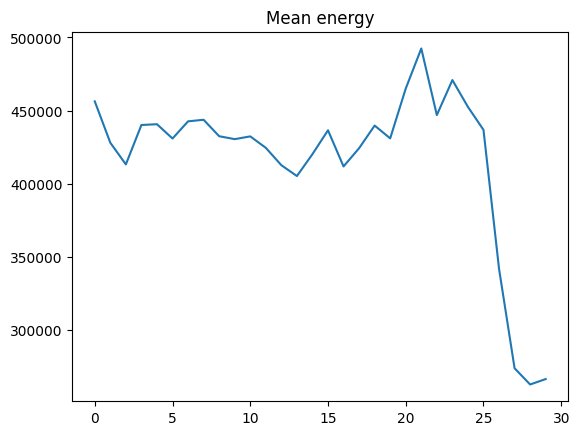

In [392]:
plt.plot(normaliized[:, best_energy])
plt.title("Energy with highest std dev")
plt.show()

plt.plot(np.mean(normaliized, axis=1))
plt.title("Mean energy")
plt.show()

plt.plot(np.mean(energy_matrix, axis=1))
plt.title("Mean energy")
plt.show()


#### LBP
Local binary patterns - histogram of different texture patterns.

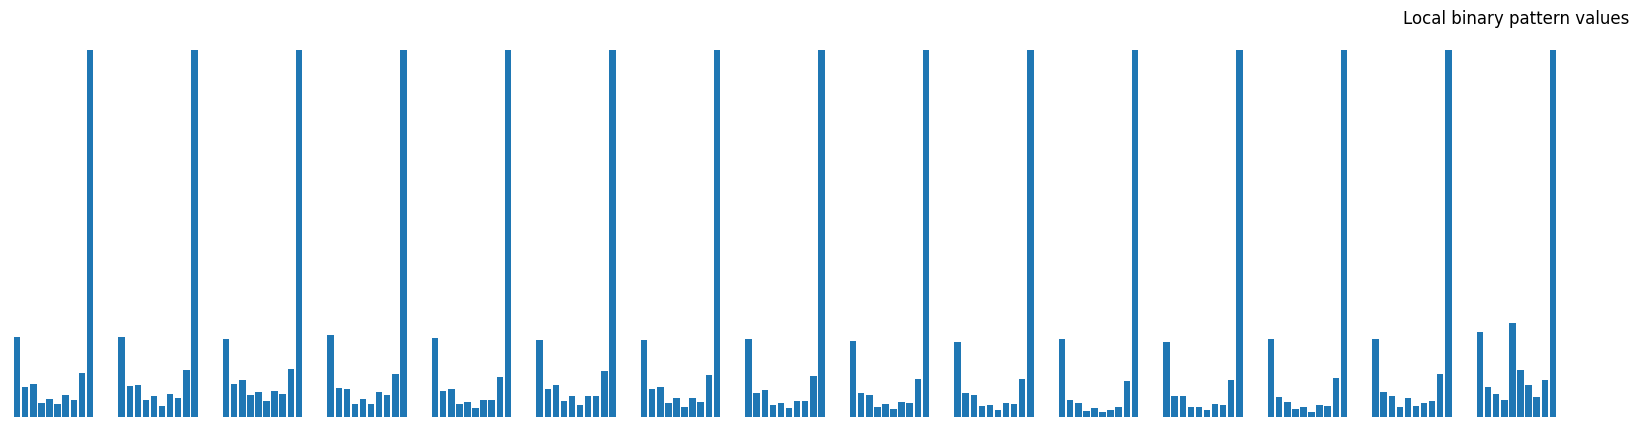

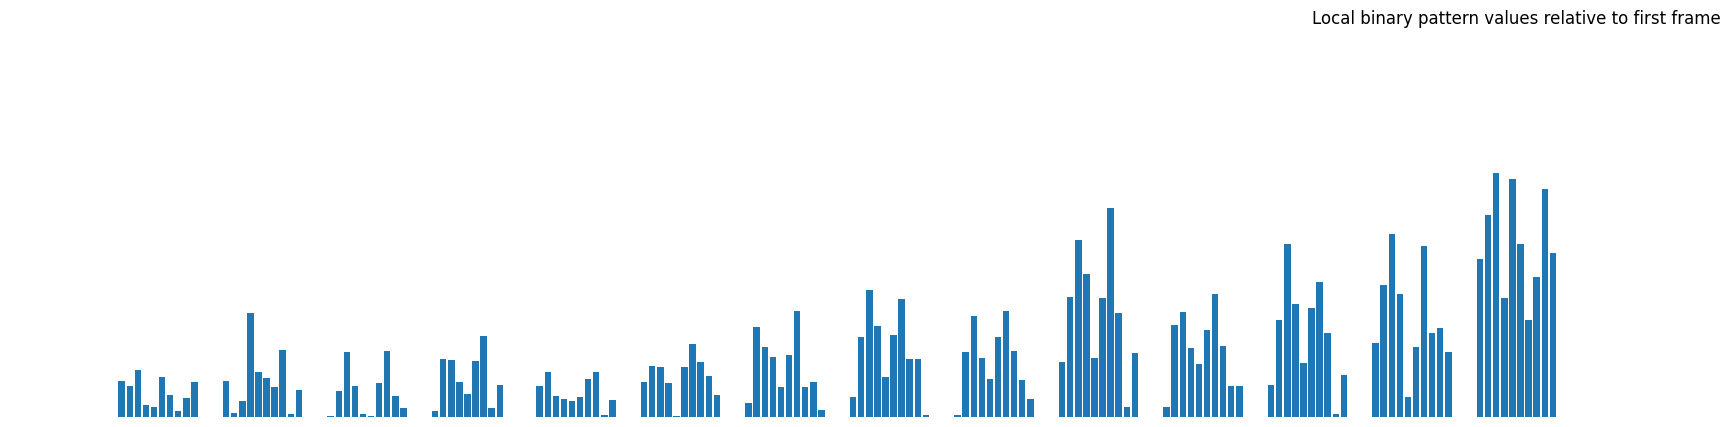

In [393]:
cors = de.GetCellDescriptorTimeline(cell_id, "Local binary pattern", 0)

n = min(15, len(cors)-2)

stride = int(np.ceil(len(cors) / n))
sampled = cors[::stride]

data = []
_, ax = plt.subplots(1, len(sampled), figsize=(20, 5))
for idx, cor in enumerate(sampled):
    ax[idx].bar(range(len(cor[1])), cor[1])
    ax[idx].axis("off")
    data.append(cor[1])
plt.title("Local binary pattern values")
plt.show()
data = np.array(data)

normalized = data / np.max(data, axis=0)
medi = normalized[0]
_, ax = plt.subplots(1, len(sampled), figsize=(20, 5))
for idx, cor in enumerate(sampled):
    ax[idx].bar(range(len(cor[1])), np.abs(normalized[idx] - medi))
    ax[idx].axis("off")
    ax[idx].set_ylim(0, 1)
plt.title("Local binary pattern values relative to first frame")
plt.show()

2
10


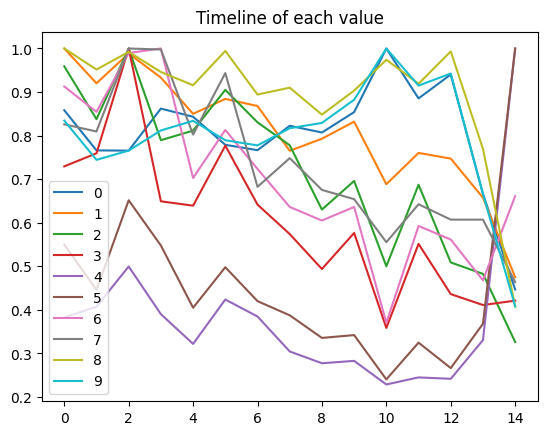

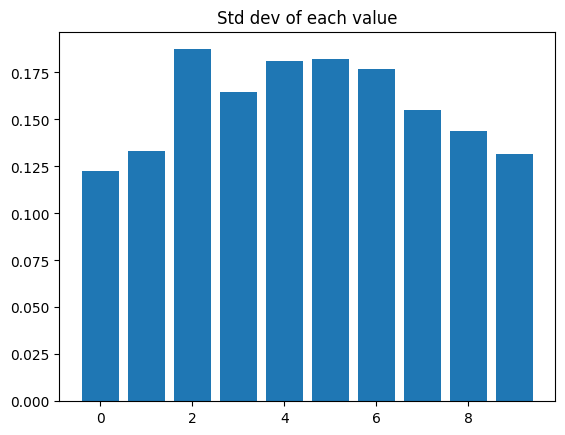

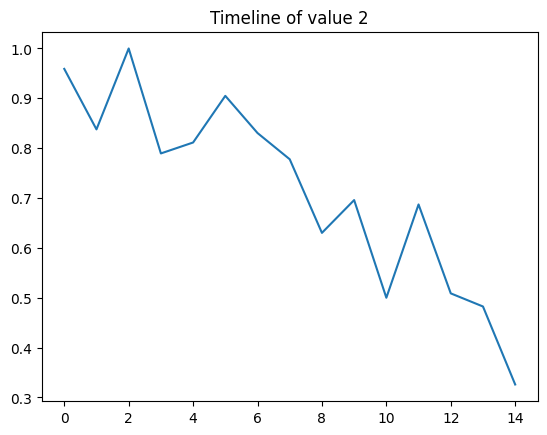

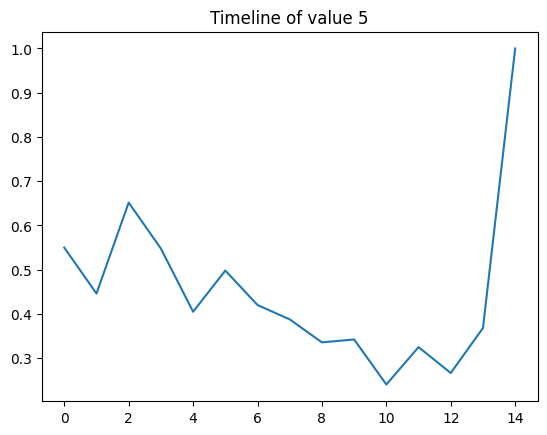

In [394]:
std_devs = np.std(normalized, axis=0)
print(np.argmax(std_devs))

print(len(normalized[0]))
plt.plot(normalized[:, :])
plt.legend(np.arange(0, len(normalized[0])))
plt.title("Timeline of each value")
plt.show()

plt.bar(range(len(normalized[0])), std_devs)
plt.title("Std dev of each value")
plt.show()

plt.plot(normalized[:,2])
plt.title("Timeline of value 2")
plt.show()

plt.plot(normalized[:,5])
plt.title("Timeline of value 5")
plt.show()
